In [2]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, haswell)
  Threads: 2 on 32 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/cuda-10.1/lib64::/.singularity.d/libs
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [1]:
# set the output format of gr backend to png while the default is svg, which disappears in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

@time using StatsPlots; 
@time gr(fmt = :png)

  3.452319 seconds (3.78 M allocations: 202.593 MiB, 6.04% gc time)
  0.000054 seconds (5 allocations: 576 bytes)
  0.316263 seconds (187.81 k allocations: 11.804 MiB)
  0.000041 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [ ]:
using CSV
using DataFrames
using Turing
using Logging
using StatsBase
using Random
using LaTeXStrings
using Dagitty

#using StatisticalRethinking
using StatisticalRethinking: link  # import explicitly, because Turing has link method also
using StatisticalRethinkingPlots

default(label=false)
Logging.disable_logging(Logging.Warn);

- CairoMakie outputs images in png by default and can be viewed in jupyter pages.

In [5]:
#using CairoMakie
#v = rand(10,2)
#CairoMakie.scatter(v[:,1], v[:,2], rasterize = true, markersize = 30.0)

#using StatsPlots
#StatsPlots.scatter(v[:,1], v[:,2], fmt=:png)


# 5.1 Spurious association

## Code 5.1 Load and standardize data

In [4]:
@time using CairoMakie
@time using PairPlots

  0.000204 seconds (140 allocations: 13.148 KiB)
  0.000102 seconds (140 allocations: 13.148 KiB)


In [5]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))

50×13 DataFrame
 Row │ Location              Loc      Population  MedianAgeMarriage  Marriage  ⋯
     │ String31              String3  Float64     Float64            Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Alabama               AL             4.78               25.3      20.2  ⋯
   2 │ Alaska                AK             0.71               25.2      26.0
   3 │ Arizona               AZ             6.33               25.8      20.3
   4 │ Arkansas              AR             2.92               24.3      26.4
   5 │ California            CA            37.25               26.8      19.1  ⋯
   6 │ Colorado              CO             5.03               25.7      23.5
   7 │ Connecticut           CT             3.57               27.6      17.1
   8 │ Delaware              DE             0.9                26.6      23.1
   9 │ District of Columbia  DC             0.6                29.7      17.7  ⋯
  10 │ Florida               FL            18.8                26.4      17.0
  11 │ Georgia               GA             9.69               25.9      22.1
  ⋮  │          ⋮               ⋮         ⋮               ⋮             ⋮      ⋱
  41 │ South Dakota          SD             0.81               25.6      20.1
  42 │ Tennessee             TN             6.35               25.2      19.4  ⋯
  43 │ Texas                 TX            25.15               25.2      21.5
  44 │ Utah                  UT             2.76               23.3      29.6
  45 │ Vermont               VT             0.63               26.9      16.4
  46 │ Virginia              VA             8.0                26.4      20.5  ⋯
  47 │ Washington            WA             6.72               25.9      21.4
  48 │ West Virginia         WV             1.85               25.0      22.2
  49 │ Wisconsin             WI             5.69               26.3      17.2
  50 │ Wyoming               WY             0.56               24.2      30.7  ⋯
                                                   8 columns and 29 rows omitted

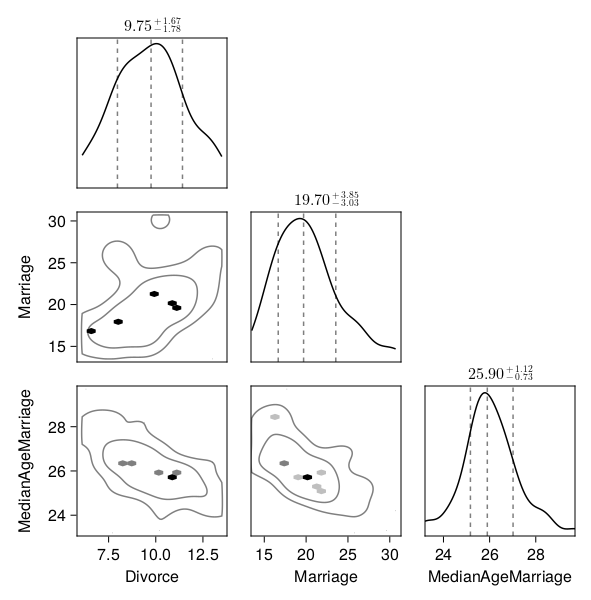

In [6]:
pairplot(d[!, [:Divorce, :Marriage, :MedianAgeMarriage]])

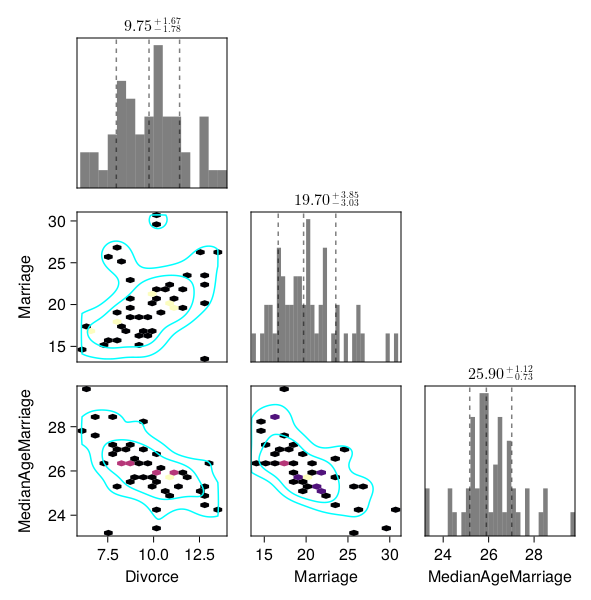

In [9]:
pairplot(
    d[!, [:Divorce, :Marriage, :MedianAgeMarriage]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

In [7]:
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

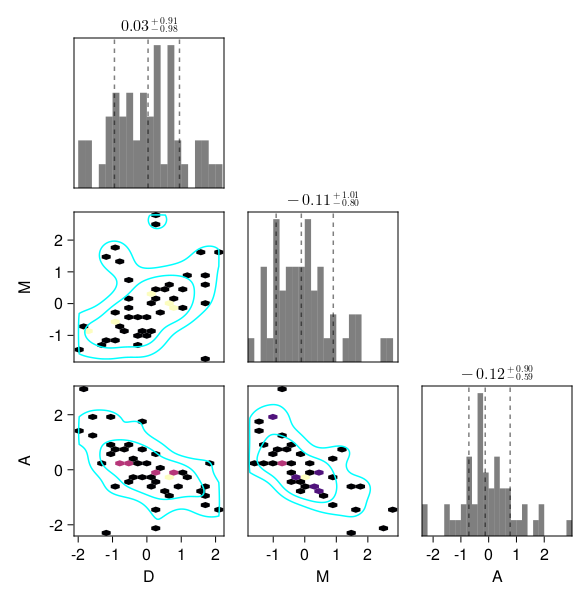

In [11]:
pairplot(
    d[!, [:D, :M, :A]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

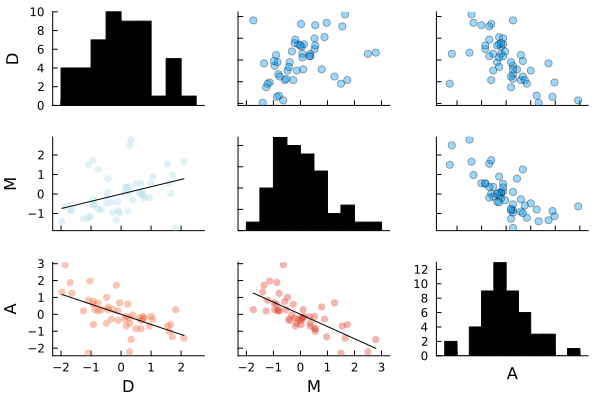

In [8]:
@df d corrplot([:D :M :A]; seriestype=:scatter, bins=10, grid=false)

## Code 5.2 stddev of median marriage age

In [12]:
std(d.MedianAgeMarriage)

1.2436303013880823

## Code 5.3 Model M5_1: Age at Marriage -> Divorce rate

In [13]:
Random.seed!(100)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

# sample 1000 iterations with real data
m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
@show m5_1

m5_1 = MCMC chain (1000×15×1 Array{Float64, 3})


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 12.82 seconds
Compute duration  = 12.82 seconds
parameters        = σ, a, bA
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.8226    0.0803    0.0023   1218.6982   709.6336    1.0020    ⋯
           a   -0.0043    0.1016    0.0028   1310.2927   714.9924    1.0021    ⋯
          bA   -0.5724    0.1205    0.0033   1311.3950   762.5789    1.0004    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0% 

In [14]:
m5_1_df = DataFrame(m5_1)
m5_1_df

1000×3 DataFrame
  Row │ a             bA         σ        
      │ Float64       Float64    Float64  
──────┼───────────────────────────────────
    1 │  0.0244318    -0.537766  0.941469
    2 │ -0.011772     -0.453882  0.740754
    3 │ -0.000747491  -0.774858  0.781651
    4 │ -0.0536445    -0.390834  0.893161
    5 │  0.0181929    -0.554014  0.757287
    6 │  0.0181929    -0.554014  0.757287
    7 │  0.0123558    -0.61193   0.837631
    8 │ -0.0326483    -0.505217  0.792938
    9 │ -0.016406     -0.561018  0.794867
   10 │ -0.016406     -0.561018  0.794867
   11 │ -0.016406     -0.561018  0.794867
  ⋮   │      ⋮            ⋮         ⋮
  991 │ -0.04403      -0.341417  0.749194
  992 │  0.0502978    -0.800271  0.89155
  993 │  0.0277825    -0.562749  0.781176
  994 │ -0.0263008    -0.577971  0.705772
  995 │ -0.0132625    -0.594546  0.833114
  996 │ -0.0156206    -0.549039  0.76805
  997 │  0.00286483   -0.594669  0.733891
  998 │ -0.029258     -0.621062  0.795776
  999 │ -0.0285305    -0.640313  0.792047
 1000 │  0.0467917    -0.532945  0.766856
                          979 rows omitted

In [15]:
# sample with no data
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
@show prior

prior = MCMC chain (1000×4×1 Array{Float64, 3})


Chains MCMC chain (1000×4×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.86 seconds
Compute duration  = 0.86 seconds
parameters        = σ, a, bA
internals         = lp

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.9553    0.9783    0.0313   1015.4453   843.7002    0.9998    ⋯
           a    0.0055    0.1969    0.0067    873.6150   953.3990    0.9995    ⋯
          bA    0.0098    0.5203    0.0157   1097.6799   940.7185    1.0007    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0241    0.2857    0.6734    1.2961    3.5540
           a   -0.4092   -0.1228    0.0031    0

In [16]:
prior_df = DataFrame(prior);
prior_df

1000×3 DataFrame
  Row │ a           bA           σ         
      │ Float64     Float64      Float64   
──────┼────────────────────────────────────
    1 │ -0.0952983   0.346801    2.80228
    2 │  0.325326    0.0330887   0.0767166
    3 │ -0.0309668  -0.198111    0.50455
    4 │ -0.109984    0.764847    0.407339
    5 │  0.233796   -0.526402    0.770479
    6 │ -0.271454   -0.615795    2.35955
    7 │  0.701263   -0.048402    0.393459
    8 │ -0.0821773   1.42475     1.10033
    9 │  0.0981873   0.412537    0.67552
   10 │  0.282137    0.347992    2.36842
   11 │  0.134045    0.453307    0.362426
  ⋮   │     ⋮            ⋮           ⋮
  991 │  0.128407    0.184859    0.446145
  992 │  0.108414   -0.467398    2.24356
  993 │  0.216761    0.0342389   0.553952
  994 │ -0.0626132  -0.755962    0.28585
  995 │  0.203006    0.523535    0.916785
  996 │ -0.0145595  -0.203639    0.443774
  997 │  0.284289    0.649125    0.33244
  998 │ -0.27817     0.692366    0.846638
  999 │  0.20555     0.00762739  0.0568282
 1000 │  0.11577    -0.0591077   0.350662
                           979 rows omitted

## Code 5.4 Simulate from priors

  0.083484 seconds (58.04 k allocations: 3.734 MiB, 99.88% compilation time)
size(μ) = (2,)
size(μ[1]) = (1000,)
size(vcat(μ)) = (2,)
size(vcat(μ...)) = (2000,)
size(vcat(μ')) = (1, 2)
size(vcat(μ'...)) = (2, 1000)
size(hcat(μ)) = (2, 1)
size(hcat(μ...)) = (1000, 2)
size(hcat(μ')) = (1, 2)
size(hcat(μ'...)) = (1, 2000)
size(μ) = (1000, 2)


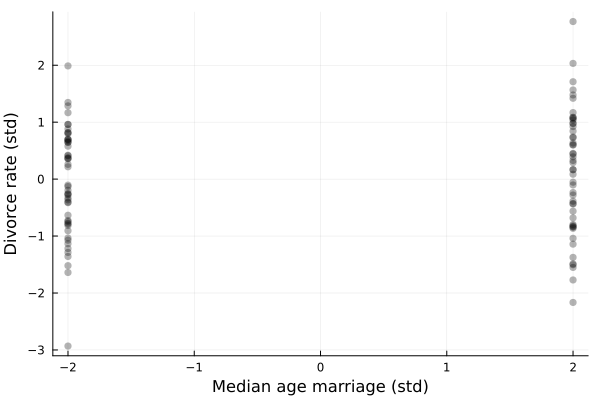

In [17]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
@time μ = link(prior_df, [:a, :bA], bounds)
@show size(μ)
@show size(μ[1])
@show size(vcat(μ))
@show size(vcat(μ...))
@show size(vcat(μ'))
@show size(vcat(μ'...))
@show size(hcat(μ))
@show size(hcat(μ...))
@show size(hcat(μ'))
@show size(hcat(μ'...))

μ = hcat(μ...);
@show size(μ)

# fmt=:png is unnecessary if gr(fmt=:png) is run beforehand.
p = Plots.scatter(xlab="Median age marriage (std)", ylab="Divorce rate (std)", fmt = :png)
for μₚ ∈ first(eachrow(μ), 50)
    Plots.scatter!(bounds, μₚ; c=:black, alpha=0.3, fmt = :png)
end
display(p)

In [18]:
import StatsPlots

In [19]:
i = 0
for μₚ ∈ first(eachrow(μ), 50)
    i+=1
    #println(size(hcat(μₚ...)))
end
i

50

In [20]:
i=0
for μₚ ∈ eachrow(μ)
    i+=1
    #println(size(hcat(μₚ...)))
end
i

1000

## Code 5.5 Plot M5_1 (Divorce-rate ~ Age at marriage) and 89%-CI/PI(Percentile Interval)

size(μ) = (30,)
size(μ) = (1000, 30)
size(μ_mean) = (30,)
size(μ_PI) = (30,)
size(μ_PI) = (30, 2)


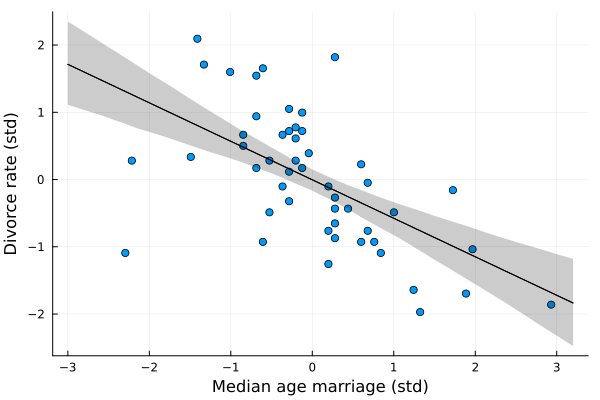

In [21]:
A_seq = range(-3, 3.2; length=30)

μ = link(m5_1_df, [:a, :bA], A_seq)
@show size(μ)

μ = hcat(μ...)
@show size(μ)

μ_mean = mean.(eachcol(μ))
@show size(μ_mean)

μ_PI = PI.(eachcol(μ))
@show size(μ_PI)

μ_PI = vcat(μ_PI'...)
@show size(μ_PI)

@df d Plots.scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
Plots.plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

## Code 5.6 M5_2: Marriage rate ->  Divorce-rate and 89%-CI/PI(Percentile Interval)

In [22]:
Random.seed!(100)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

@time m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
print(m5_2)
m5_2_df = DataFrame(m5_2);
m5_2_df

  7.611075 seconds (6.93 M allocations: 492.286 MiB, 5.83% gc time, 95.79% compilation time)
MCMC chain (1000×15×1 Array{Float64, 3})

1000×3 DataFrame
  Row │ a            bM        σ        
      │ Float64      Float64   Float64  
──────┼─────────────────────────────────
    1 │ -0.099085    0.431999  0.970973
    2 │ -0.00898628  0.188715  0.869539
    3 │  0.00576532  0.510824  0.967043
    4 │  0.0023617   0.135649  0.873527
    5 │ -0.00583311  0.249348  0.918568
    6 │  0.103296    0.406378  0.878395
    7 │  0.21369     0.222688  1.22729
    8 │  0.26529     0.345047  1.01489
    9 │ -0.0668167   0.329049  0.952299
   10 │  0.0148825   0.523886  1.06919
   11 │  0.0515816   0.371632  0.932291
  ⋮   │      ⋮          ⋮         ⋮
  991 │  0.016051    0.231128  0.935855
  992 │  0.108495    0.380852  0.895655
  993 │ -0.114166    0.425528  1.07433
  994 │  0.11264     0.287303  0.839731
  995 │  0.0133943   0.44427   1.00933
  996 │ -0.0680566   0.266753  0.78158
  997 │  0.0281641   0.362513  0.949367
  998 │ -0.00528464  0.13945   0.97829
  999 │  0.172721    0.452914  0.867904
 1000 │ -0.0678864   0.30576   1.04677
                        979 rows omitted

In [23]:
m5_2

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.31 seconds
Compute duration  = 5.31 seconds
parameters        = σ, a, bM
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.9511    0.0939    0.0028   1141.1385   572.7905    1.0027    ⋯
           a    0.0025    0.1157    0.0034   1132.6733   771.3853    1.0010    ⋯
          bM    0.3513    0.1302    0.0037   1285.6732   699.6500    1.0007    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%   

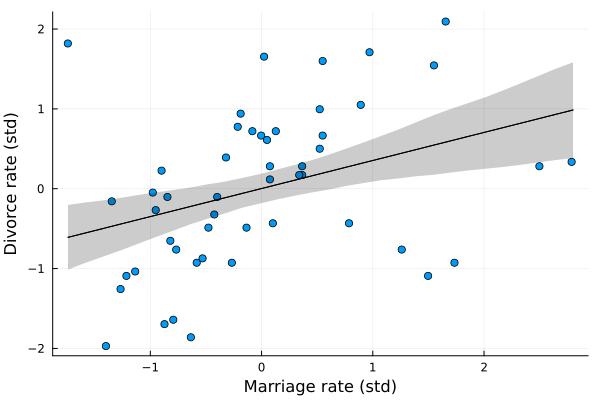

In [24]:
M_seq = range(-1.74, 2.8; length=30)

μ = link(m5_2_df, [:a, :bM], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d Plots.scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
Plots.plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

## Code 5.7 DAG1: (Directed Acyclic Graph)/Causal relationship for Divorce rate

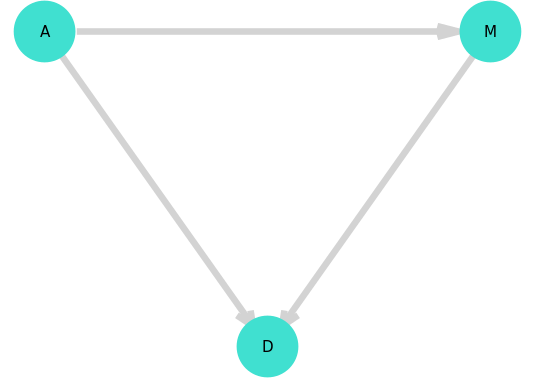

In [25]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
drawdag(g, [0, 1, 2], [0, 1, 0])

In [26]:
?drawdag

search: drawdag



```
drawdag(dag; layout=spring_layout, ...)
```

Draws dag with given layout method (check GraphPlot package for their description)

---

```
drawdag(dag, locs_x, locs_y)
```

Draws dag with given locations of every node

# Examples

```julia
julia> g = DAG(:A => :C, :C => :B)
DAG: {3, 2} directed simple Int64 graph with labels [:A, :B, :C])

julia> drawdag(g, [0, 0, 1], [0, 1, 1])
```


## Code 5.8 DAG2 and there is one conditional independence

implied_conditional_independencies(g) = ConditionalIndependence[ConditionalIndependence(:D, :M, [:A])]


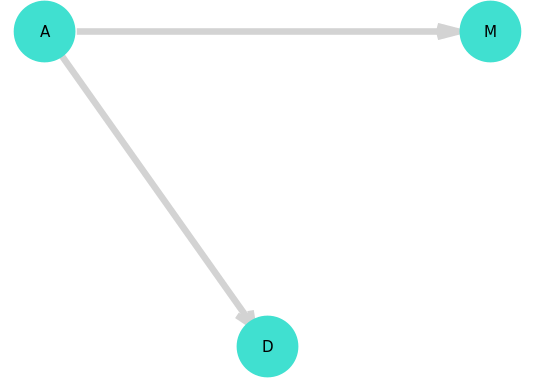

In [27]:
g = Dagitty.DAG(:A => :M, :A => :D)
@show implied_conditional_independencies(g)
drawdag(g, [0, 1, 2], [0, 1, 0])

Conditoinal indendence: P(D,M|A) = P(D|A) * P(M|A)

## Code 5.9 No conditional independence for DAG1

In [28]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
implied_conditional_independencies(g)

ConditionalIndependence[]

## Code 5.10 M5_3: Age at marriage + Marriage-rate -> Divorce rate

In [29]:
@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3)
precis(m5_3_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.0004  0.0983  -0.1538  -0.0034   0.1551  ▁▁▁▂▄▇██▇▄▂▁▁▁ │
│    bA │ -0.6045   0.161  -0.8547  -0.6058  -0.3498     ▁▁▁▃▆██▆▃▁▁ │
│    bM │ -0.0543  0.1604  -0.3145  -0.0538   0.1995     ▁▂▄▆█▆▄▂▁▁▁ │
│     σ │  0.8268  0.0831   0.7062   0.8211   0.9637  ▁▂▅▇█▆▄▂▁▁▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 5.11 Plot coefficients of different models above

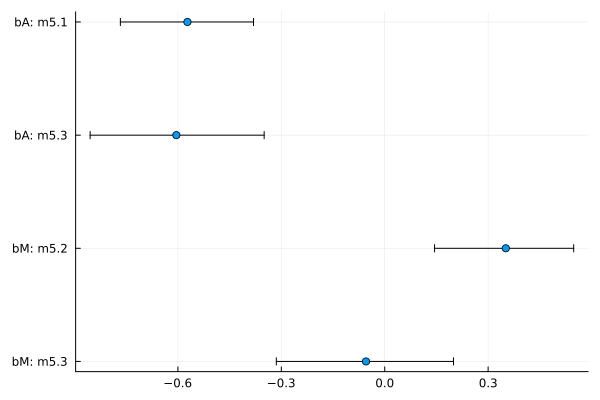

In [30]:
coeftab_plot(m5_1_df, m5_2_df, m5_3_df; pars=(:bA, :bM), names=["m5.1", "m5.2", "m5.3"])

## Code 5.12 Plot coefficients of a simulated model (A -> M, A-> D but no causality between M and D)

In [31]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age));

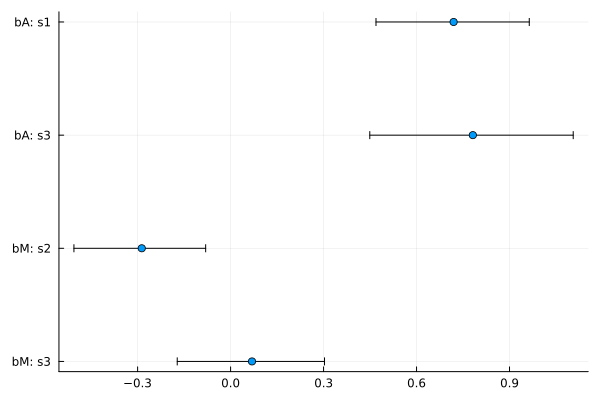

In [32]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

### 5.12.1 Simulate a A -> M, A+M -> D model and plot coefficients of the fitted model

In [33]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age .+ mar));

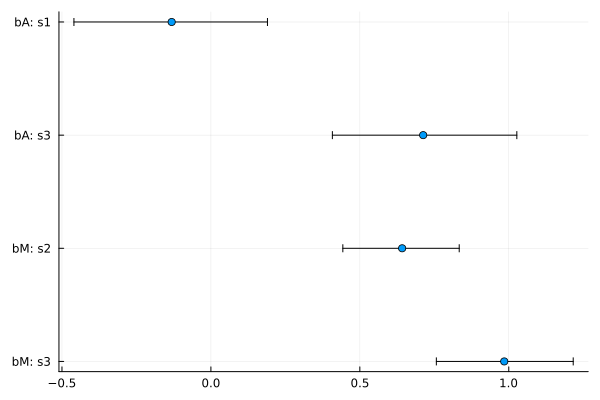

In [34]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

## Code 5.13 M5.4: An Age -> Marriage_rate model

In [35]:
Random.seed!(100)

@model function model_m5_4(A, M)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ = @. a + bAM * A
    M ~ MvNormal(μ, σ)
end

m5_4 = sample(model_m5_4(d.A, d.M), NUTS(), 1000)
m5_4_df = DataFrame(m5_4);

In [36]:
m5_4

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.31 seconds
Compute duration  = 5.31 seconds
parameters        = σ, a, bAM
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.7157    0.0748    0.0024   1040.7863   541.3318    1.0010    ⋯
           a    0.0001    0.0823    0.0023   1289.0902   836.3366    0.9990    ⋯
         bAM   -0.6904    0.1037    0.0029   1325.5622   644.1833    1.0068    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%  

## Code 5.14 Plot residuals of Age -> Marriage-rate model

In [37]:
mu = link(m5_4_df, [:a, :bAM], d.A);
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_resid = mu_mean .- d.M;

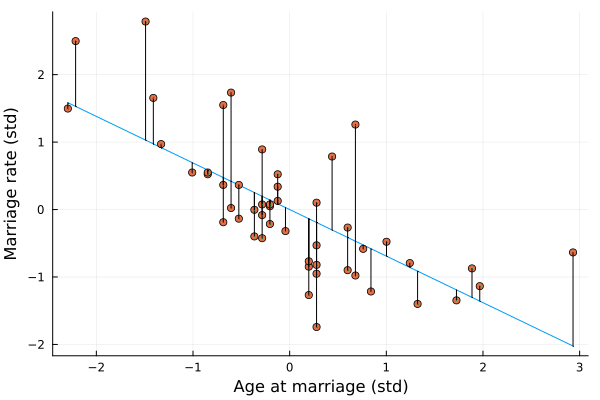

In [38]:
# Side-note: how to plot the residuals
# getting yerr - list of 2-tuples with distance to the regression line
yerr = collect(zip(-clamp.(mu_resid, -Inf, -0.0), clamp.(mu_resid, 0, Inf)));

StatsPlots.plot(d.A, mu_mean; xlab="Age at marriage (std)", ylab="Marriage rate (std)")
StatsPlots.scatter!(d.A, d.M)
StatsPlots.scatter!(d.A, d.M; yerr=yerr, markersize=0)

## Code 5.15 Simulate M5_3

In [39]:
fun = (r,(a,m)) -> r.a + r.bA*a + r.bM*m
mu = link(m5_3_df, fun, zip(d.A, d.M))
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

fun = (r, (a,m)) -> Normal(r.a+r.bA*a+r.bM*m, r.σ)
D_sim = simulate(m5_3_df, fun, zip(d.A, d.M))
D_sim = vcat(D_sim'...);
D_PI = PI.(eachcol(D_sim))
D_PI = vcat(D_PI'...);

### Code 5.16 Plot simulations of M5_3

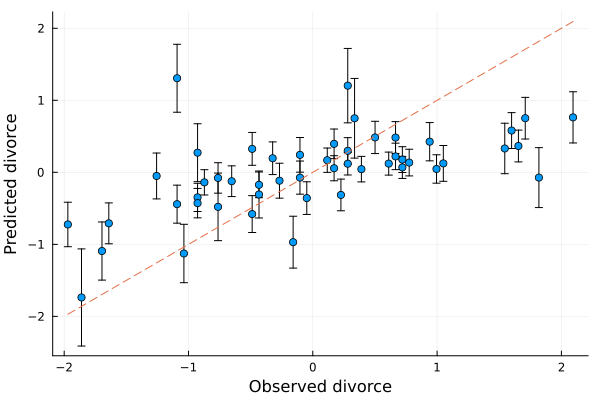

In [40]:
yerr = mu_PI[:,2] .- mu_mean
StatsPlots.scatter(d.D, mu_mean; xlab="Observed divorce", ylab="Predicted divorce", yerr=yerr)
StatsPlots.plot!(x->x; style=:dash)

### Code 5.17 Find the outlier states of M5_3

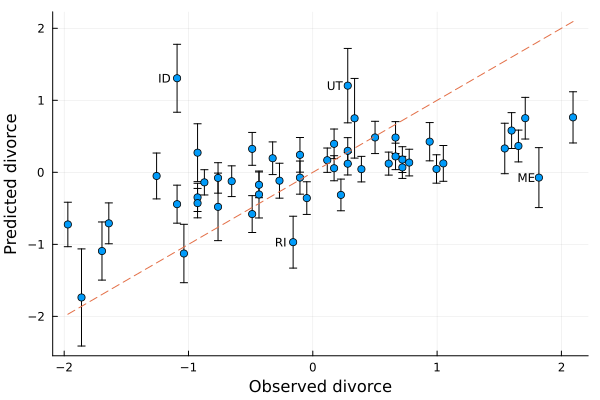

In [41]:
loc_flags = d.Loc .∈ (["ID", "UT", "RI", "ME"],);
loc_idxes = findall(loc_flags);
anns = [
    (d.D[idx] - 0.1, mu_mean[idx], (d.Loc[idx], 8))
    for idx in loc_idxes
]
annotate!(anns)

## 5.18 Simulate spurious association

x_real ~ N(0,1)

x_spur ~ N(x_real, 1)

y ~ N(x_real, 1)

$$ y = a + \beta_1 * x_{real} + \beta_2 * x_{spur} + \epsilon$$

=> $\beta_2 = 0 $ => $x_{spur}$ is useless.

In [42]:
Random.seed!(100)
N = 100
x_real = rand(Normal(), N)
x_spur = rand.(Normal.(x_real))
y = rand.(Normal.(x_real))
df = DataFrame(:y => y, :x_real => x_real, :x_spur => x_spur);

In [43]:
df

100×3 DataFrame
 Row │ y           x_real      x_spur     
     │ Float64     Float64     Float64    
─────┼────────────────────────────────────
   1 │  1.58308     1.0516      0.542426
   2 │ -1.38233    -0.676855   -1.20993
   3 │ -0.873461   -0.167043   -0.821533
   4 │ -1.19174    -0.943461   -2.41842
   5 │ -0.0975013   0.0437185   0.695274
   6 │  0.186308   -0.381812   -2.86091
   7 │ -1.61618    -0.731897   -1.1923
   8 │  0.881373    0.849668    1.17135
   9 │ -1.26316     0.364817   -1.33369
  10 │  1.30763     0.107224    1.32903
  11 │ -1.12375     0.672998    0.292225
  ⋮  │     ⋮           ⋮           ⋮
  91 │  0.168477    0.0432416   0.0161798
  92 │ -1.9169      0.107003    0.639926
  93 │ -3.07585    -1.70532    -2.05718
  94 │  0.507224    1.42892     0.747264
  95 │ -2.75159    -1.2744     -1.69204
  96 │  1.52546     0.552733    0.220615
  97 │ -1.23522    -0.514352   -2.12476
  98 │  1.55436    -0.350671   -0.171626
  99 │  1.00172     0.32285    -1.24937
 100 │  1.52672     0.305797    1.52835
                           79 rows omitted

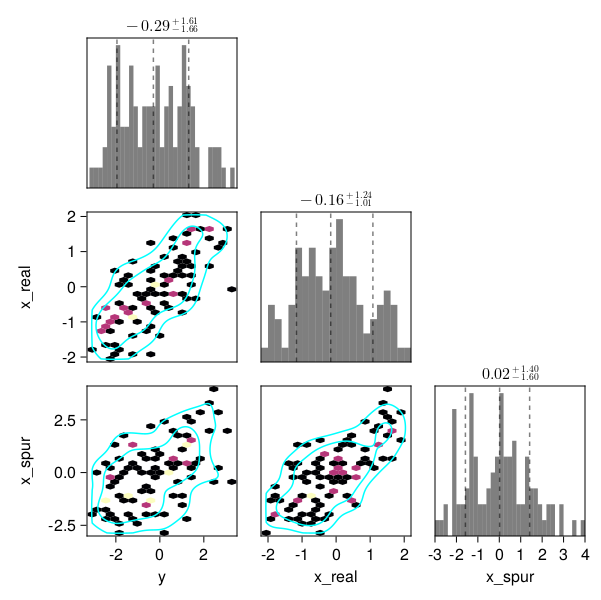

In [44]:

pairplot(
    df => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

## 5.19 M5_3A: Fit data to a simulated model: A → D ← M and A → M

In [45]:
d1 = DataFrame(CSV.File("data/WaffleDivorce.csv"))
# standardize data
d = DataFrame(
    :D => standardize(ZScoreTransform, d1.Divorce),
    :M => standardize(ZScoreTransform, d1.Marriage),
    :A => standardize(ZScoreTransform, d1.MedianAgeMarriage),
);

@model function model_m5_3A(A, M, D)
    # A → D ← M
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
    # A → M
    σ_M ~ Exponential(1)
    aM ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ_M = @. aM + bAM * A
    M ~ MvNormal(μ_M, σ_M)
end

@time m5_3A = sample(model_m5_3A(d.A, d.M, d.D), NUTS(), 1000)
m5_3A_df = DataFrame(m5_3A)
precis(m5_3A_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.0053  0.0964  -0.1468   0.0052   0.1591   ▁▁▂▄▆██▆▄▃▁▁▁ │
│    aM │  0.0032  0.0868  -0.1332   0.0025   0.1394  ▁▁▂▃▆██▆▄▂▁▁▁▁ │
│    bA │ -0.6055  0.1614  -0.8738  -0.6028  -0.3492     ▁▂▃▆██▆▃▁▁▁ │
│   bAM │ -0.6951  0.1041  -0.8686  -0.6918   -0.529   ▁▁▂▄▆▇█▇▄▂▁▁▁ │
│    bM │ -0.0628  0.1594  -0.3134  -0.0642   0.1965     ▁▁▂▄▇█▆▃▂▁▁ │
│     σ │  0.8269  0.0844    0.699   0.8211   0.9637   ▁▂▄██▇▄▂▁▁▁▁▁ │
│   σ_M │  0.7102  0.0707   0.6084   0.7059   0.8296      ▁▁▆██▅▂▂▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


### 5.20 A range of A (Age at marriage) to be manipulated

In [46]:
A_seq = range(-2, 2; length=30);

### 5.21 Output M and D given the range of A and the fitted M5_3A model

In [55]:
s_M, s_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    push!(s_M, M)
    push!(s_D, D)
end
@show size(s_M)
@show size(s_M')
@show size(s_D)
@show size(hcat(s_M'...))
@show size(hcat(s_M...))

s_M = vcat(s_M'...)
s_D = vcat(s_D'...);
@show size(s_M)
@show size(s_D)

size(s_M) = (1000,)
size(s_M') = (1, 1000)
size(s_D) = (1000,)
size(hcat(s_M'...)) = (1, 30000)
size(hcat(s_M...)) = (30, 1000)
size(s_M) = (1000, 30)
size(s_D) = (1000, 30)


(1000, 30)

### Code 5.22 Plot A on D and A on M

size(PI_D) = (30, 2)


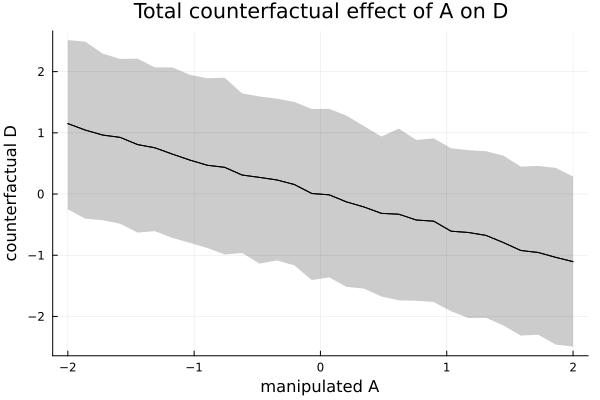

In [56]:
μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)
@show size(PI_D)

Plots.plot(
    A_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manipulated A", ylab="counterfactual D",
    title="Total counterfactual effect of A on D"
)

size(PI_M) = (30, 2)


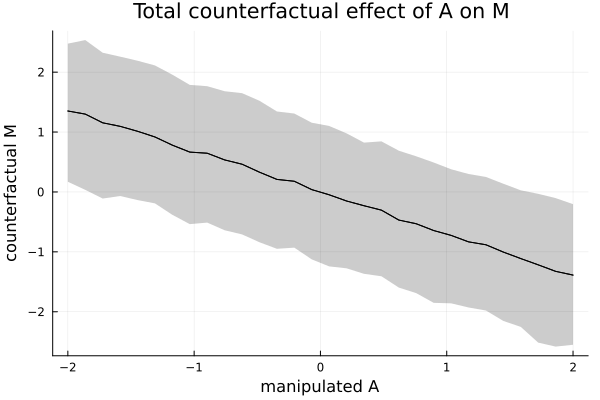

In [57]:
μ_M = mean.(eachcol(s_M))
PI_M = vcat(PI.(eachcol(s_M))'...)
@show size(PI_M)

Plots.plot(
    A_seq, [μ_M, μ_M]; 
    fillrange=PI_M, fillalpha=0.2, color=:black,
    xlab="manipulated A", ylab="counterfactual M",
    title="Total counterfactual effect of A on M"
)

### Code 5.23 Effect on Divorce rate and Marriage rate after increasing median marriage age from 20 to 30

In [59]:
# new data frame, standardized to mean 26.1 and stddev 1.24
@show sim2_A = @. ([20, 30] - 26.1) / 1.24;
@show size(sim2_A)
s2_M, s2_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * sim2_A), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * sim2_A + r.bM * M), r.σ))
    push!(s2_M, M)
    push!(s2_D, D)
end

@show size(s2_M)
@show size(s2_D)
@show first(s2_M,3)
s2_M = vcat(s2_M'...)
s2_D = vcat(s2_D'...);
@show size(s2_M)
@show size(s2_D)
mean(s2_D[:,2] - s2_D[:,1])

sim2_A = #= In[59]:2 =# @__dot__(([20, 30] - 26.1) / 1.24) = [-4.919354838709679, 3.1451612903225796]
size(sim2_A) = (2,)
size(s2_M) = (1000,)
size(s2_D) = (1000,)
first(s2_M, 3) = Any[[4.385906201067672, -1.0957154772676465], [2.3770994936969285, -3.192847551090166], [2.8371944990791733, -2.5965759749285002]]
size(s2_M) = (1000, 2)
size(s2_D) = (1000, 2)


-4.489583910493244

### 5.24 Plot M on D (little effect)

size(M_seq) = (30,)
size(s_D) = (1000,)
size(s_D) = (1000, 30)
size(μ_D) = (30,)
size(PI_D) = (30, 2)


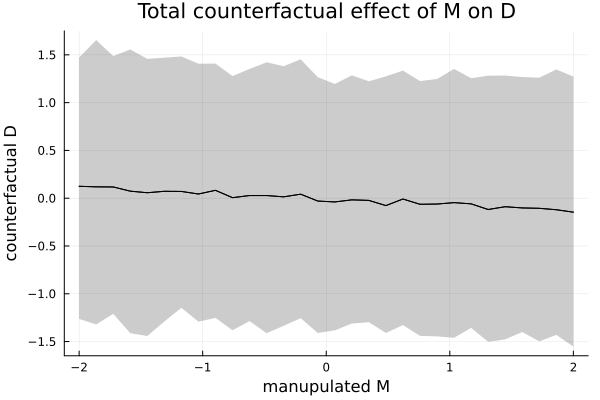

In [61]:
M_seq = range(-2, 2; length=30)
@show size(M_seq)
s_D = []

for r ∈ eachrow(m5_3A_df)
    # A is zero, so, we drop it from the μ term
    D = rand(MvNormal((@. r.a + r.bM * M_seq), r.σ))
    push!(s_D, D)
end

@show size(s_D)
s_D = vcat(s_D'...);
@show size(s_D)

μ_D = mean.(eachcol(s_D))
@show size(μ_D)

PI_D = vcat(PI.(eachcol(s_D))'...)
@show size(PI_D)

Plots.plot(
    M_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated M", ylab="counterfactual D",
    title="Total counterfactual effect of M on D"
)

## 5.25 How counterfactuals are simulated. First generate list of A.

In [63]:
A_seq = range(-2, 2; length=30);

In [64]:
@show size(A_seq)
A_seq

size(A_seq) = (30,)


-2.0:0.13793103448275862:2.0

### 5.26 Use simulate() to generate M given A from StatisticalRethinking

In [65]:
s_M = simulate(m5_3A_df, (r,a) -> Normal(r.aM + r.bAM*a), A_seq)
@show size(s_M)
s_M = vcat(s_M'...);
@show size(s_M)


size(s_M) = (1000,)
size(s_M) = (1000, 30)


(1000, 30)

In [54]:
s_M

1000×30 Matrix{Float64}:
  1.92794    1.54085    1.15432    …  -0.767491   -2.7444     -3.46183
  0.908773  -0.479218   0.0938201      0.585955   -0.389276   -2.13534
 -0.413785  -1.43165   -0.581544      -2.78697    -0.759363   -2.34133
  1.59478    1.12136    1.27017       -1.04614    -1.83813    -1.15212
  2.2436     0.72524    1.40694        0.271442   -1.55346     0.0525702
  1.90278    0.665031  -0.588684   …  -0.452422   -0.981543   -0.909611
  1.1571     1.71416    1.42744       -0.0405939   0.0214152  -0.835301
  1.23463    2.83735    3.03306       -2.09665    -0.831248   -3.08976
  2.92929    1.23717    2.67232       -0.520378    0.392671   -3.09773
  1.98068   -0.282545   1.68077       -1.69156    -1.65223     0.970884
  0.343166   0.551395  -0.899405   …  -2.23484    -1.49966    -1.02469
  0.528834   1.93167    1.18061       -2.32996    -1.73243    -1.7349
  1.85232    1.52049    0.976049      -1.03517    -0.614021   -2.24822
  ⋮                                ⋱            

In [68]:
parentmodule(simulate)

StatisticalRethinking

In [67]:
?simulate

search: simulate



# simulate

Used for counterfactual simulations.

```julia
simulate(df, coefs, var_seq)

```

### Required arguments

```julia
* `df`                                 : DataFrame with coefficient samples
* `coefs`                              : Vector of coefficients
* `var_seq`                            : Input values for simulated effect
```

### Return values

```julia
* `m_sim::NamedTuple`                  : Array with predictions
```

---

# simulate

Counterfactual predictions after manipulating a variable.

```julia
simulate(df, coefs, var_seq, coefs_ext)

```

### Required arguments

```julia
* `df`                                 : DataFrame with coefficient samples
* `coefs`                              : Vector of coefficients
* `var_seq`                            : Input values for simulated effect
* `ext_coefs`                          : Vector of simulated variable coefficients
```

### Return values

```julia
* `(m_sim, d_sim)`                     : Arrays with predictions
```

---

# simulate

Generic simulate of predictions using callable returning distribution to sample from.

```julia
simulate(df, rx_to_dist, xrange; return_dist, seed)

```

## Required arguments

  * `df::DataFrame`: data frame with parameters in each row
  * `rx_to_dist::Function`: callable with two arguments: row object and x value. Have to return `Distribution` instance.
  * `xrange`: iterable with arguments

## Optional arguments

  * `return_dist::Bool = false`: if set to `true`, distributions will be returned, not their samples
  * `seed::Int = missing`: sets the random seed

## Return value

Vector were each item is generated from every item in xrange argument. Each item is again a vector obtained from `rx_to_dist` call to obtain a distribution and then sample from it. If argument `return_dist=true`, sampling step will be omitted.

## Examples

```jldoctest
julia> using StatisticalRethinking, DataFrames, Distributions

julia> d = DataFrame(:mu => [1.0, 2.0], :sigma => [0.1, 0.2])
2×2 DataFrame
 Row │ mu       sigma
     │ Float64  Float64
─────┼──────────────────
   1 │     1.0      0.0
   2 │     2.0      0.0

julia> simulate(d, (r,x) -> Normal(r.mu+x, r.sigma), 0:1)
2-element Vector{Vector{Float64}}:
 [1.0, 2.0]
 [2.0, 3.0]

julia> simulate(d, (r,x) -> Normal(r.mu+x, r.sigma), 0:1, return_dist=true)
2-element Vector{Vector{Normal{Float64}}}:
 [Normal{Float64}(μ=1.0, σ=0.0), Normal{Float64}(μ=2.0, σ=0.0)]
 [Normal{Float64}(μ=2.0, σ=0.0), Normal{Float64}(μ=3.0, σ=0.0)]

```


### 5.27 Use simulate() to generate D given A and M from StatisticalRethinking

In [71]:
# joining M into dataframe with parameters
t = DataFrame(m5_3A_df)
@show size(t)
@show typeof(collect(eachrow(s_M)))
t[!,:M] = collect(eachrow(s_M));
@show size(t)
@show first(t, 3)
@show size(zip(A_seq, 1:30))
@show first(zip(A_seq, 1:30), 3)

s_D = simulate(t, (r,(a,m_i)) -> Normal(r.a + r.bA*a + r.bM*r.M[m_i], r.σ), zip(A_seq, 1:30))
@show size(s_D)
s_D = vcat(s_D'...);
@show size(s_D)

size(t) = (1000, 7)
typeof(collect(eachrow(s_M))) = Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}
size(t) = (1000, 8)
first(t, 3) = 3×8 DataFrame
 Row │ a            aM           bA         bAM        bM          σ         σ_M       M
     │ Float64      Float64      Float64    Float64    Float64     Float64   Float64   SubArray…
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  0.0340914    0.00873866  -0.555966  -0.73627    0.0507512  0.922466  0.746614  [2.04332, 0.718865, 1.3248, 2.79…
   2 │ -0.00603654   0.00743811  -0.719597  -0.53481   -0.17087    0.699771  0.706022  [1.44721, 1.1635, 1.05168, -0.94…
   3 │ -0.0838747   -0.0818532   -0.575852  -0.572106  -0.0317733  0.87072   0.723837  [1.3783, 0.643529, 0.794528, -2.…
size(zip(A_seq, 1:30)) = (30,)
first(zip(A_seq, 1:30), 3) = [(-2.0, 1), (-1.8620689655172413, 2), (-1.7241379310344827, 3)]
size(s_D

(1000, 30)

In [81]:
size(hcat(first(t,1).M'...))

(1, 30)

In [73]:
s_D

1000×30 Matrix{Float64}:
  1.2545     1.1389      0.60824    …  -2.52423    -0.712716   -0.712666
  0.764716   1.52654     0.354801      -0.23773    -1.10724    -1.68639
 -0.0396853  1.02284     1.85791       -0.572608   -1.7757     -0.282853
  0.282111   0.253276    0.450529       0.414791   -1.36294    -1.47447
 -0.215194   1.11618     2.18138       -0.216356   -2.21086    -1.60904
  0.902087   1.85944     0.347862   …  -0.467589   -1.19076    -1.20201
  1.17589    2.07654     0.374388      -1.85327     0.0443127  -1.36653
  2.03046    0.0931789   0.663804      -0.80299    -1.53804    -0.872049
  0.259794   2.36088     1.47493       -1.17499    -1.17441    -2.80804
  1.84711    1.51664    -0.0771494     -0.918311    0.619097   -0.928196
  1.08515    1.24057     1.76023    …  -1.06612    -0.324067   -2.5789
  2.17098    0.114109   -0.506712      -0.938644   -1.4309     -1.65352
  1.65082    1.8335      1.58991       -1.03261    -1.59732    -0.912625
  ⋮                                

# 5.2 Masked relationship

## 5.28 Load the MILK dataset

In [92]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

@show first(d,3)
# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

@show size(d)
describe(d)

first(d, 3) = 3×8 DataFrame
 Row │ clade          species         kcal.per.g  perc.fat  perc.protein  perc.lactose  mass     neocortex.perc
     │ String31       String31        Float64     Float64   Float64       Float64       Float64  Float64?
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42         67.98     1.95           55.16
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91         63.82     2.09      missing
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85         69.04     2.51      missing
size(d) = (29, 8)


8×7 DataFrame
 Row │ variable        mean      min         median  max                       ⋯
     │ Symbol          Union…    Any         Union…  Any                       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ clade                     Ape                 Strepsirrhine             ⋯
   2 │ species                   A palliata          Symphalangus syndactylus
   3 │ kcal_per_g      0.641724  0.46        0.6     0.97
   4 │ perc_fat        33.9903   3.93        36.84   55.51
   5 │ perc_protein    16.4034   7.37        15.8    25.3                      ⋯
   6 │ perc_lactose    49.6062   27.09       48.64   71.91
   7 │ mass            14.7269   0.12        3.47    97.72
   8 │ neocortex_perc  67.5759   55.16       68.85   76.3
                                                               2 columns omitted

In [83]:
first(d, 3)

3×8 DataFrame
 Row │ clade          species         kcal_per_g  perc_fat  perc_protein  perc ⋯
     │ String31       String31        Float64     Float64   Float64       Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42       ⋯
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85
                                                               3 columns omitted

In [ ]:
?rename

In [ ]:
?replace

In [91]:
typeof('.' => '_')

Pair{Char, Char}

## 5.29 Standardize and remove missing

In [94]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:M] = standardize(ZScoreTransform, log.(d.mass))

# column contains missing values, need to propagate them on standartization
d[!,:N] = d.neocortex_perc
non_miss = findall(!ismissing, d.N);
@show non_miss
@show size(non_miss)

d[non_miss,:N] = standardize(ZScoreTransform, disallowmissing(d.N[non_miss]));
first(d, 3)

non_miss = [1, 6, 7, 8, 10, 11, 12, 13, 16, 18, 20, 22, 24, 25, 27, 28, 29]


3×11 DataFrame
 Row │ clade          species         kcal_per_g  perc_fat  perc_protein  perc ⋯
     │ String31       String31        Float64     Float64   Float64       Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42       ⋯
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85
                                                               6 columns omitted

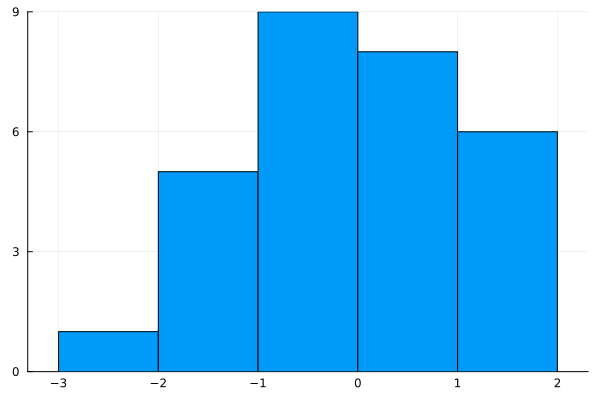

In [149]:
Plots.histogram(d[:, :M])

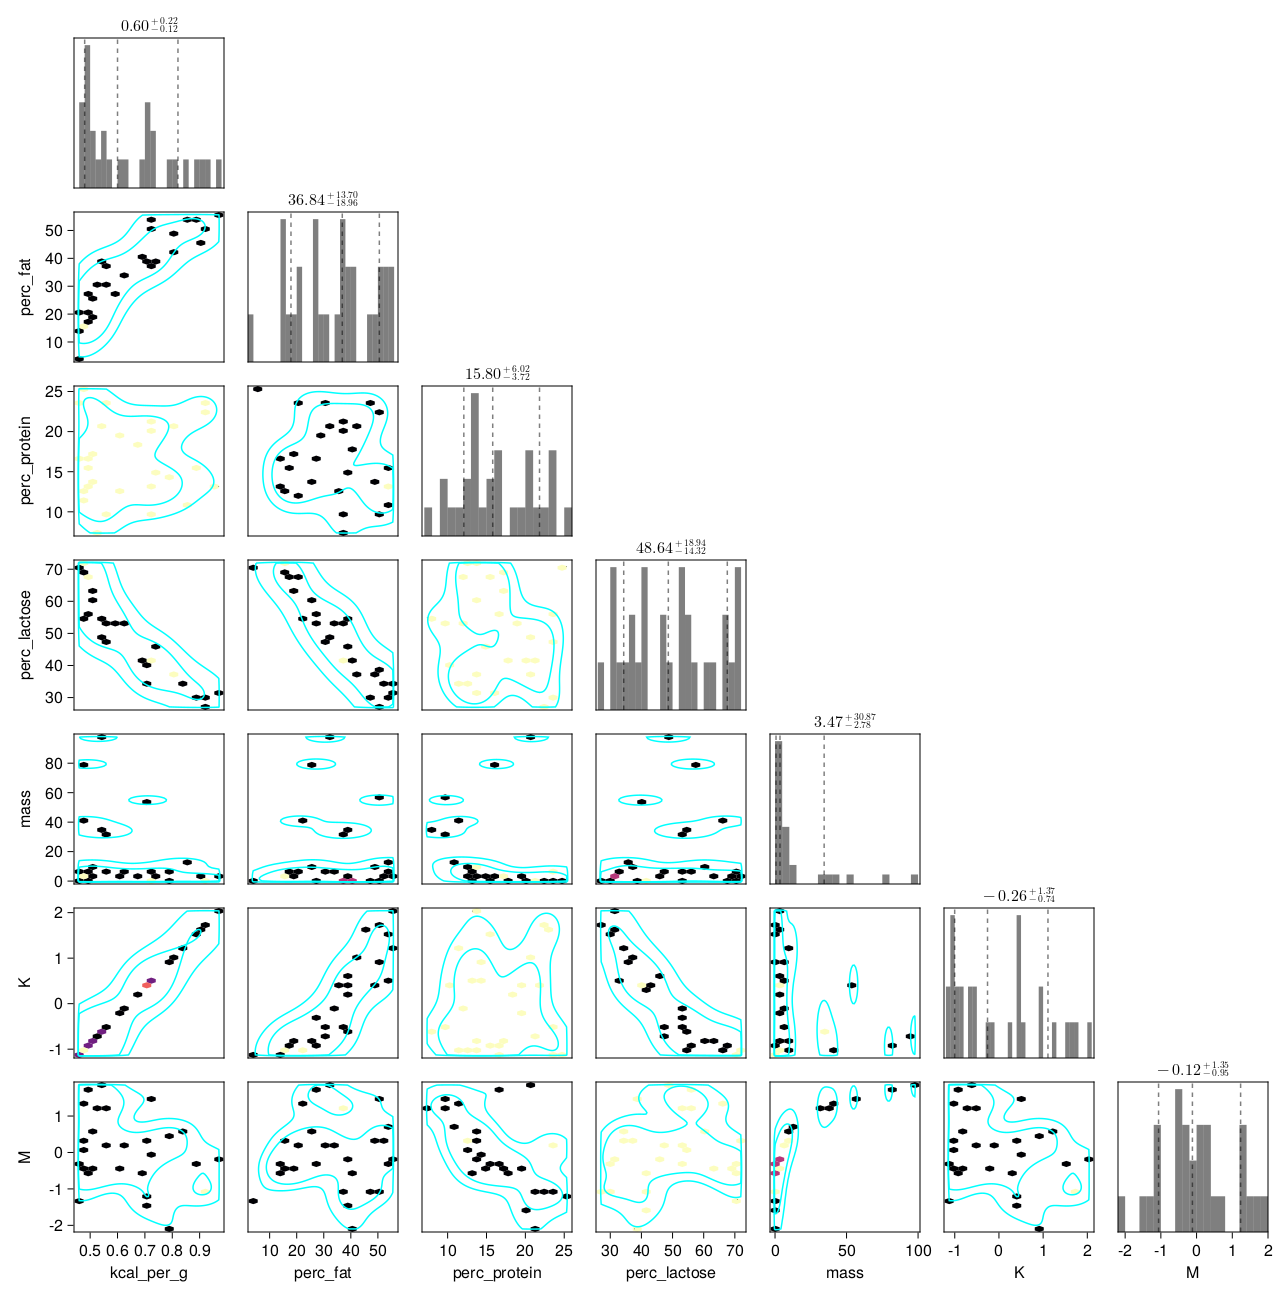

In [98]:
pairplot(
    d[!, [:kcal_per_g, :perc_fat, :perc_protein, :perc_lactose, :mass, :K, :M,]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

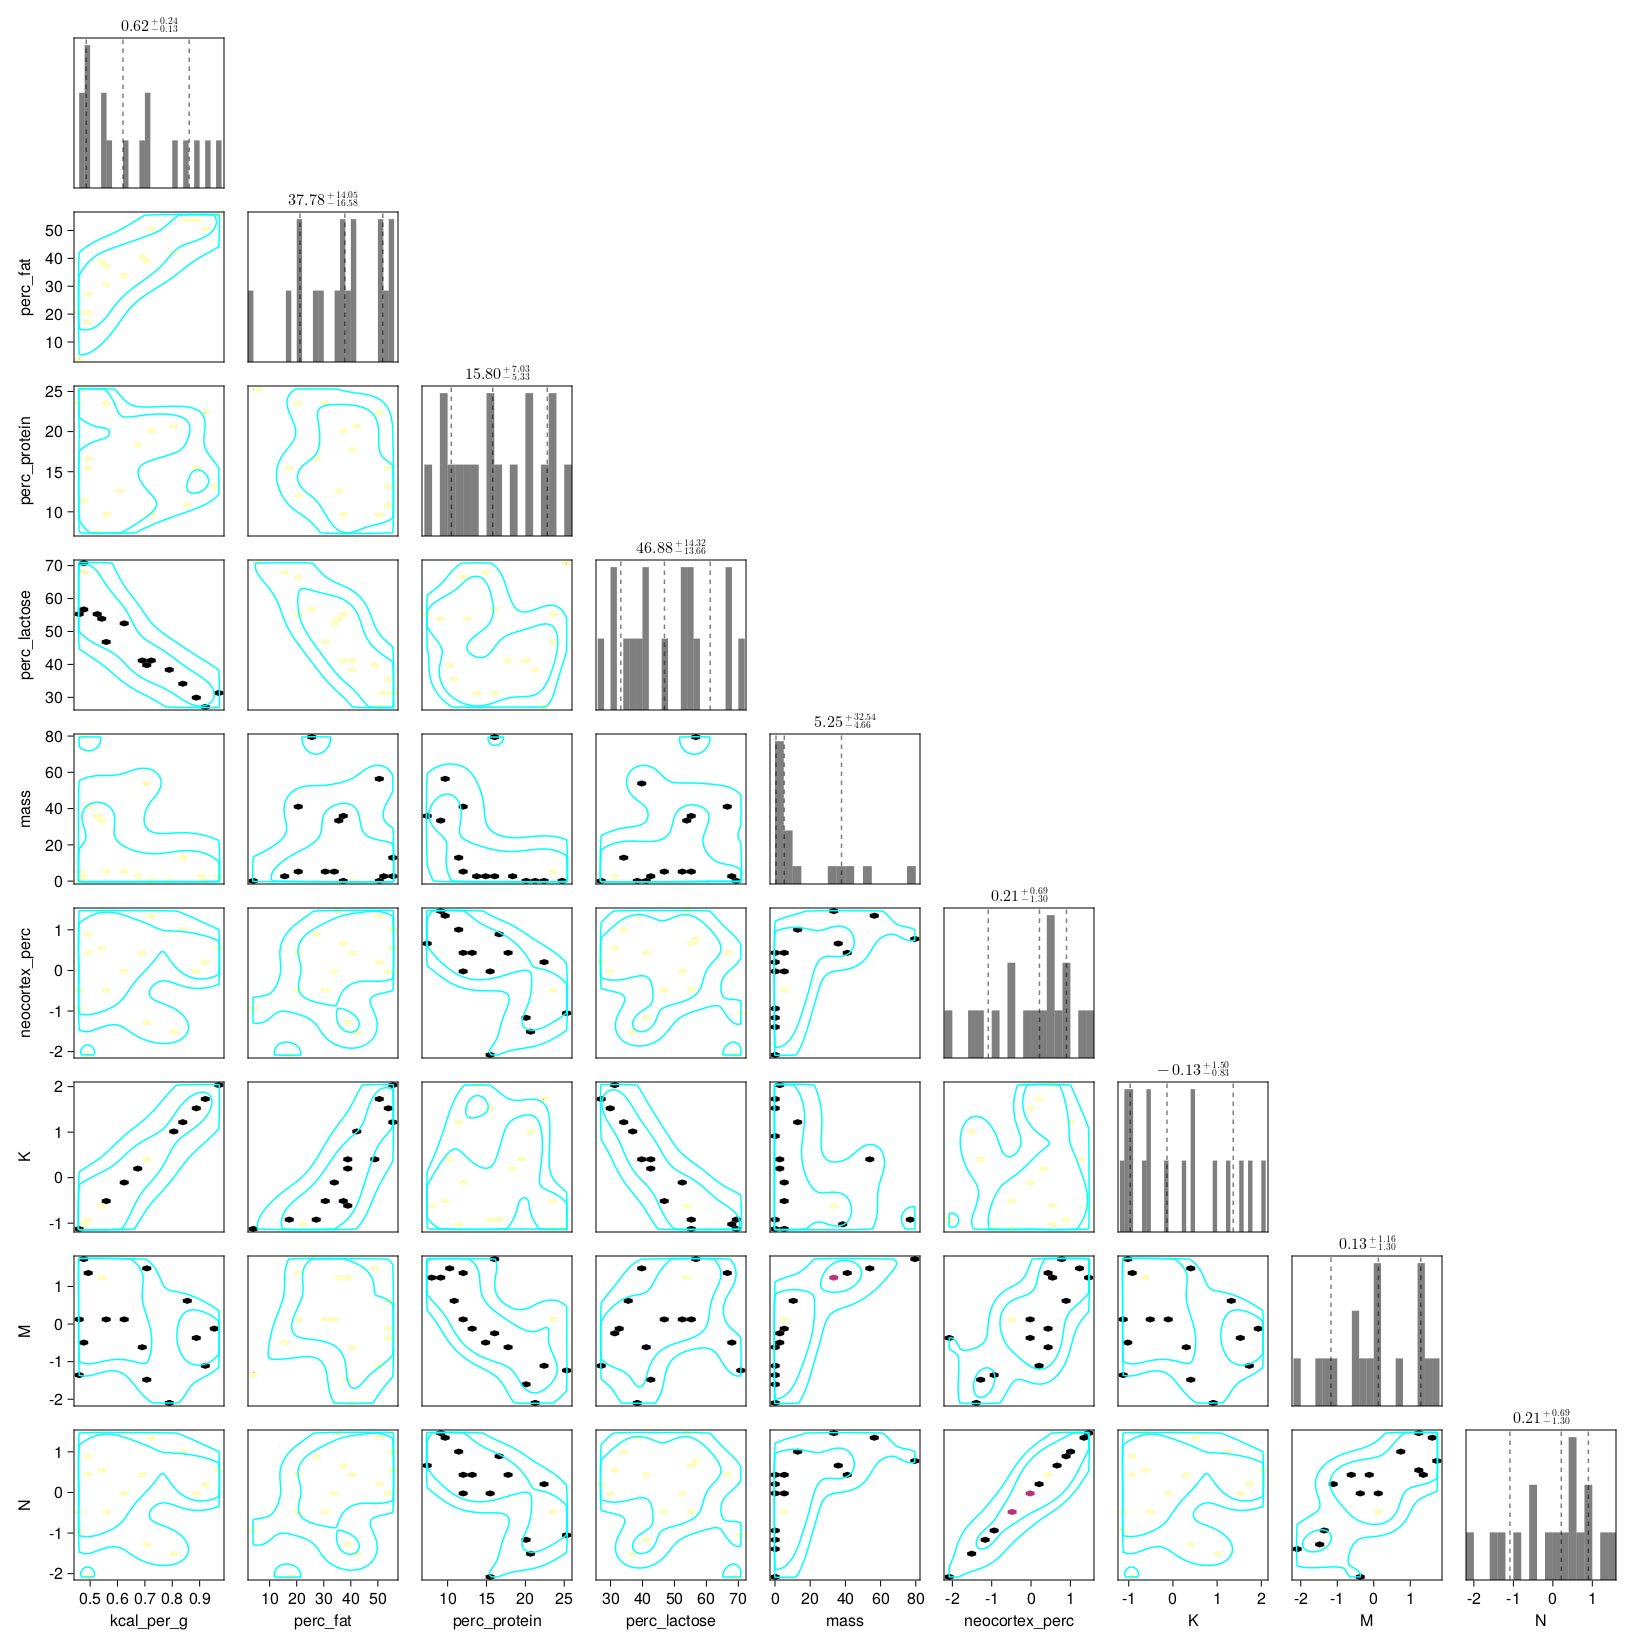

In [102]:
pairplot(
    disallowmissing(d[non_miss, [:kcal_per_g, :perc_fat, :perc_protein, :perc_lactose, :mass, :neocortex_perc, :K, :M, :N]]) => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

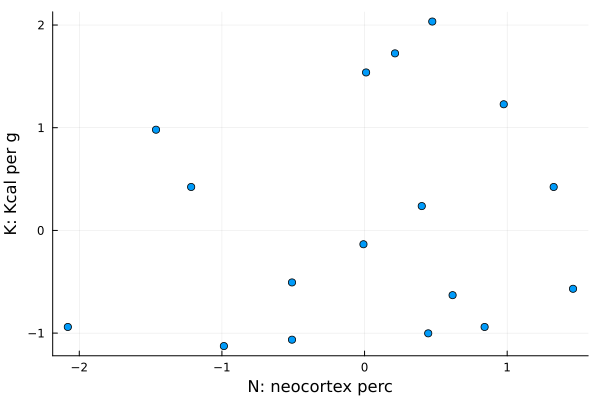

In [144]:
d_nonmiss = disallowmissing(d[non_miss, :])
Plots.scatter(d_nonmiss.N, d_nonmiss.K, ylabel="K: Kcal per g", xlabel="N: neocortex perc")

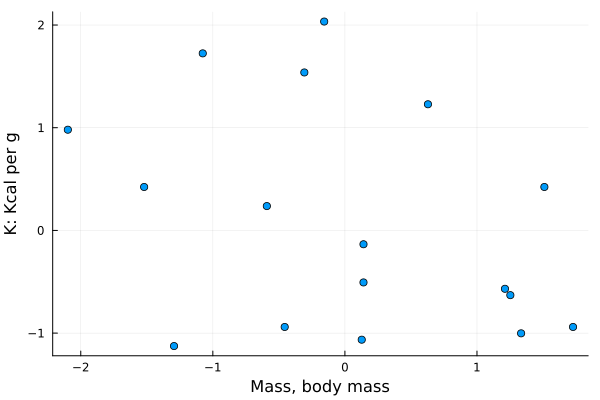

In [145]:
Plots.scatter(d_nonmiss.M, d_nonmiss.K, xlabel="Mass, body mass", ylabel="K: Kcal per g")

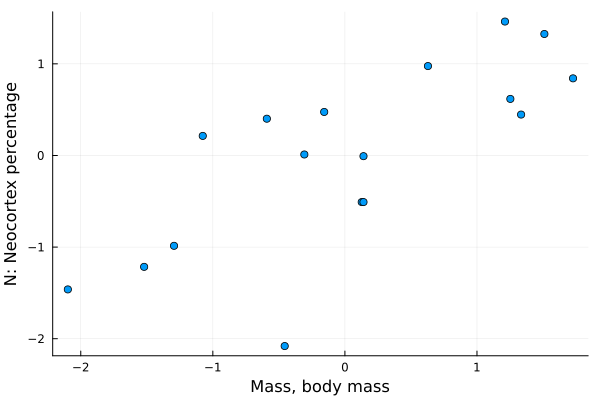

In [146]:
Plots.scatter(d_nonmiss.M, d_nonmiss.N, xlabel="Mass, body mass", ylabel="N: Neocortex percentage")

## 5.30  Model m5_5_draft: K is dependent on N. Expected to fail due to presence of missing values

In [111]:
@model function model_m5_5_draft(N, K)
    a ~ Normal(0, 1)
    bN ~ Normal(0, 1)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

try
    m5_5_draft = sample(model_m5_5_draft(d.N, d.K), NUTS(), 1000)
catch e
    if isa(e, MethodError)
        s = sprint(showerror, e)
        println(s)
    end
end

MethodError: no method matching MvNormal(::Vector{Union{Missing, Float64}}, ::Float64)

Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedVector{<:Real}, ::Real)
   @ DistributionsADTrackerExt ~/.julia/packages/DistributionsAD/rvsL2/ext/DistributionsADTrackerExt.jl:472
  MvNormal(!Matched::AbstractVector{<:Real}, ::Real)
   @ Distributions deprecated.jl:103
  MvNormal(!Matched::Int64, ::Real)
   @ Distributions deprecated.jl:103



## 5.31 Check missing values in neocortex_perc

In [60]:
d.neocortex_perc

29-element Vector{Union{Missing, Float64}}:
 -2.0801960251136564
   missing
   missing
   missing
   missing
 -0.5086412889378672
 -0.5086412889378672
  0.010742472484833622
   missing
  0.21346968258853227
 -1.4619618058717947
 -0.9861392631490621
 -1.2156733770681267
  ⋮
  0.47483699478834385
   missing
  0.9757910098379835
   missing
 -0.007687273888229892
   missing
  0.6172486713074732
  0.8417564907611553
   missing
  0.44635465948451797
  1.4616661414914773
  1.3259561909261903

In [116]:
describe(d.neocortex_perc)

Summary Stats:
Length:         29
Missing Count:  12
Mean:           -0.000000
Minimum:        -2.080196
1st Quartile:   -0.508641
Median:         0.213470
3rd Quartile:   0.617249
Maximum:        1.461666
Type:           Union{Missing, Float64}


## 5.32 Remove missing data

In [113]:
@time dcc = d[completecases(d[!,[:K,:N,:M]]),:];
@show size(dcc)

  0.000122 seconds (46 allocations: 6.094 KiB)
size(dcc) = (17, 11)


(17, 11)

In [147]:
first(dcc, 3)

3×11 DataFrame
 Row │ clade             species             kcal_per_g  perc_fat  perc_protei ⋯
     │ String31          String31            Float64     Float64   Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine     Eulemur fulvus            0.49     16.6          15.4 ⋯
   2 │ New World Monkey  Alouatta seniculus        0.47     21.22         23.5
   3 │ New World Monkey  A palliata                0.56     29.66         23.4
                                                               7 columns omitted

## 5.33 Fit m5_5_draft with no-missing data

In [114]:
@time m5_5_draft = sample(model_m5_5_draft(dcc.N, dcc.K), NUTS(), 1000);

  6.324415 seconds (5.69 M allocations: 403.922 MiB, 6.59% gc time, 94.29% compilation time)


In [115]:
m5_5_draft

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.74 seconds
Compute duration  = 5.74 seconds
parameters        = a, bN, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           a    0.0872    0.2585    0.0081   1021.5472   595.7440    1.0003    ⋯
          bN    0.1380    0.2805    0.0079   1241.9354   802.6853    1.0020    ⋯
           σ    1.1368    0.2210    0.0076    898.6074   757.8167    1.0012    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%   

## 5.34 Draw what the priors look like

size(prior_df) = (1000, 3)
size(μ) = (2,)
size(μ) = (1000, 2)


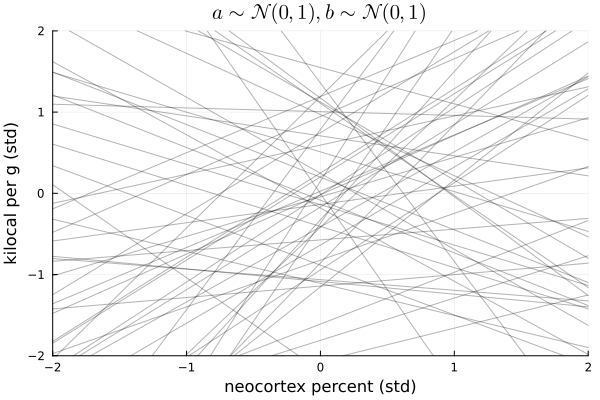

In [117]:
prior = sample(model_m5_5_draft(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)
@show size(prior_df)
xseq = [-2, 2]
μ = link(prior_df, [:a, :bN], xseq)
@show size(μ)
μ = hcat(μ...);
@show size(μ)

p = Plots.plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,1), b \sim \mathcal{N}(0,1)"
)
for y ∈ first(eachrow(μ), 50)
    Plots.plot!(p, xseq, y; c=:black, alpha=0.3)
end
#display it 
p

## 5.35 Modify the prior, narrow $\sigma$ and fit the model again

In [118]:
@model function model_m5_5(N, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

@time m5_5 = sample(model_m5_5(dcc.N, dcc.K), NUTS(), 1000)
m5_5_df = DataFrame(m5_5);
m5_5_df

  4.289605 seconds (3.89 M allocations: 279.570 MiB, 5.76% gc time, 92.52% compilation time)


1000×3 DataFrame
  Row │ a            bN            σ        
      │ Float64      Float64       Float64  
──────┼─────────────────────────────────────
    1 │  0.127945     0.105834     1.05144
    2 │  0.0723466   -0.237145     1.33797
    3 │  0.0662959   -0.0861844    1.06804
    4 │  0.170886     0.260305     1.04114
    5 │  0.170886     0.260305     1.04114
    6 │ -0.0924735   -0.000156765  1.04573
    7 │  0.209103    -0.313534     1.12193
    8 │ -0.158802     0.505653     1.05611
    9 │ -0.00463042  -0.10832      1.22358
   10 │ -0.377581    -0.23939      1.19687
   11 │  0.130904     0.521374     1.00675
  ⋮   │      ⋮            ⋮           ⋮
  991 │  0.251468     0.290711     1.34458
  992 │ -0.154141    -0.107766     0.992687
  993 │ -0.154141    -0.107766     0.992687
  994 │ -0.154141    -0.107766     0.992687
  995 │  0.092585     0.943405     1.39819
  996 │  0.0864048   -0.378484     1.43977
  997 │  0.126862    -0.0145701    1.21718
  998 │  0.103405     0.0288955    1.10335
  999 │ -0.230767     0.373227     1.07096
 1000 │  0.0208907    0.187629     1.08077
                            979 rows omitted

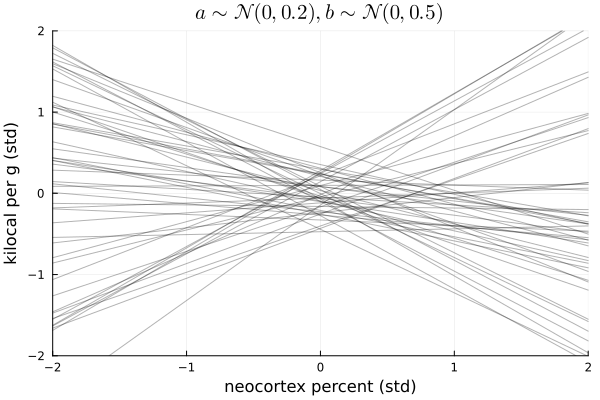

In [119]:
prior = sample(model_m5_5(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)

μ = link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p2 = Plots.plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,0.2), b \sim \mathcal{N}(0,0.5)"
)
for y ∈ first(eachrow(μ), 50)
    Plots.plot!(p2, xseq, y; c=:black, alpha=0.3)
end
#display the plot
p2

## 5.36 Precision of estimated parameters

In [66]:
precis(m5_5_df)

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%    histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 0.0436  0.1564  -0.2192  0.0496  0.2967  ▁▁▂▄▇█▇▃▂▁▁ │
│    bN │ 0.1242  0.2389  -0.2512  0.1265  0.4995   ▁▁▁▂▆█▇▃▁▁ │
│     σ │ 1.0994  0.2026   0.8415  1.0644  1.4634     ▁▆█▄▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────┘


## 5.37 Plot 89% CI of $\mu$

size(μ) = (30,)
size(μ) = (1000, 30)
size(μ_mean) = (30,)
size(μ_PI) = (30,)
size(μ_PI) = (30, 2)


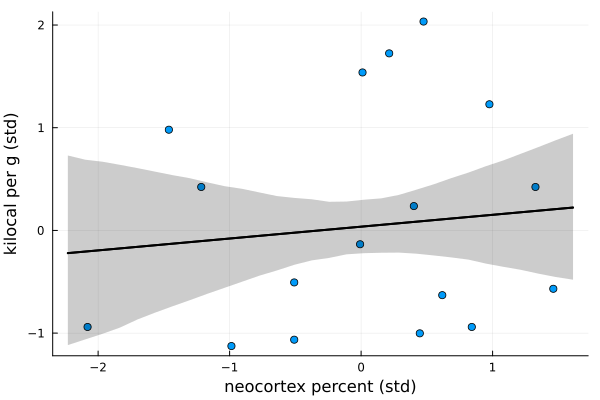

In [120]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_5_df, [:a, :bN], xseq);
@show size(μ)
μ = hcat(μ...)
@show size(μ)

μ_mean = mean.(eachcol(μ))
@show size(μ_mean)

μ_PI = PI.(eachcol(μ))
@show size(μ_PI)

μ_PI = vcat(μ_PI'...)
@show size(μ_PI)

@df dcc Plots.scatter(:N, :K; xlab="neocortex percent (std)", ylab="kilocal per g (std)")
Plots.plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

## 5.38 Model m5_6: K linearly dependent on M 

In [121]:
@model function model_m5_6(M, K)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bM * M
    K ~ MvNormal(μ, σ)
end

@time m5_6 = sample(model_m5_6(dcc.M, dcc.K), NUTS(), 1000)
m5_6_df = DataFrame(m5_6)
@show size(m5_6_df)
precis(m5_6_df)

  6.860545 seconds (5.48 M allocations: 381.538 MiB, 6.09% gc time, 95.12% compilation time)
size(m5_6_df) = (1000, 3)
┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 0.0488  0.1565  -0.1933   0.0431  0.3027    ▁▁▂▅▇█▇▄▂▁▁ │
│    bM │ -0.268  0.2154  -0.6073  -0.2693  0.0813       ▁▂▅█▆▃▁▁ │
│     σ │ 1.0601  0.1902   0.7929   1.0333  1.4016  ▁▂▆██▆▄▂▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


### m5_6: Plot M vs K

size(xseq) = (30,)
size(μ) = (30,)
size(μ) = (1000, 30)
size(μ_mean) = (30,)
size(μ_PI) = (30,)
size(μ_PI) = (30, 2)


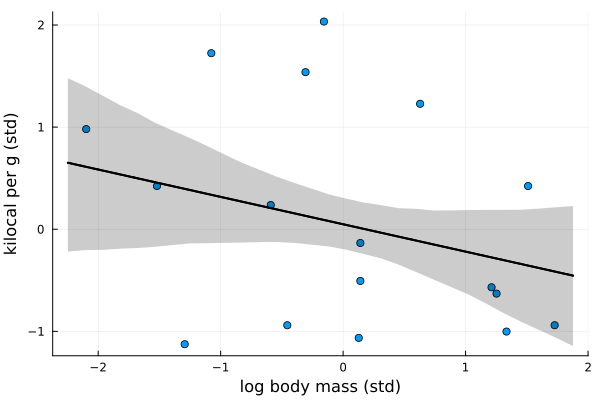

In [122]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
@show size(xseq)
μ = link(m5_6_df, [:a, :bM], xseq);
@show size(μ)

μ = hcat(μ...)
@show size(μ)

μ_mean = mean.(eachcol(μ))
@show size(μ_mean)

μ_PI = PI.(eachcol(μ))
@show size(μ_PI)

μ_PI = vcat(μ_PI'...)
@show size(μ_PI)

@df dcc Plots.scatter(:M, :K; xlab="log body mass (std)", ylab="kilocal per g (std)")
Plots.plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

## 5.39 Model m5_7: K dependent on M and N

In [124]:
@model function model_m5_7(N, M, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N + bM * M
    K ~ MvNormal(μ, σ)
end

@time m5_7 = sample(model_m5_7(dcc.N, dcc.M, dcc.K), NUTS(), 1000)
m5_7_df = DataFrame(m5_7)
@show size(m5_7_df)
precis(m5_7_df)

  8.472727 seconds (7.20 M allocations: 522.465 MiB, 6.56% gc time, 92.79% compilation time)
size(m5_7_df) = (1000, 4)
┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%    94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.0584  0.1423  -0.1673   0.0621   0.2825  ▁▁▁▃███▄▂▁▁ │
│    bM │ -0.637  0.2522  -1.0058  -0.6531  -0.2105    ▁▂▆█▇▃▁▁▁ │
│    bN │ 0.6003  0.2798   0.1231   0.6177   1.0023  ▁▁▁▂▅██▆▂▁▁ │
│     σ │ 0.8669  0.1756   0.6298   0.8488   1.1985  ▂▅██▇▄▂▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


## 5.40 Plot range of the estimated coefficients of all models

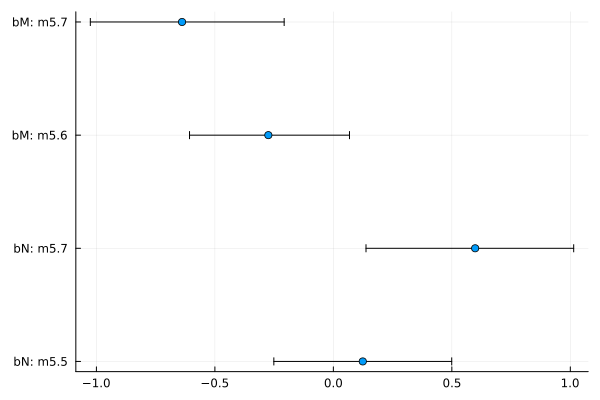

In [71]:
coeftab_plot(m5_7_df, m5_6_df, m5_5_df; pars=(:bM, :bN), names=("m5.7", "m5.6", "m5.5"))

- In m5_7, both bM and bN are much bigger than modelling M or N alone (m5_6, m5_5).
- Associations become stronger when both predictors are included. Further evidence from counterfactual plots below.
- What caused this?

## 5.41 Fig 5.9 Plot counterfactual of m5_7 while holding M=0 or N=0

The code in the book corresponds to the bottom-right figure, which keeps N=0 (despite stated in the text).

Below is the code to produce the bottom-left figure (M=0).

size(μ) = (30,)
size(μ) = (1000, 30)
size(μ_mean) = (30,)
size(μ_PI) = (30,)
size(μ_PI) = (30, 2)


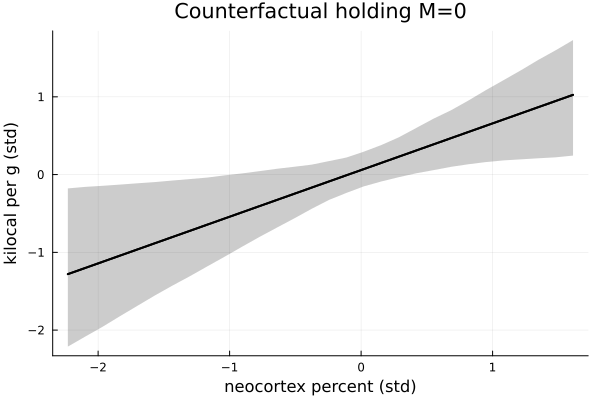

In [125]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bN], xseq);
@show size(μ)

μ = hcat(μ...)
@show size(μ)

μ_mean = mean.(eachcol(μ))
@show size(μ_mean)

μ_PI = PI.(eachcol(μ))
@show size(μ_PI)

μ_PI = vcat(μ_PI'...)
@show size(μ_PI)

Plots.plot(title="Counterfactual holding M=0", 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)")
Plots.plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

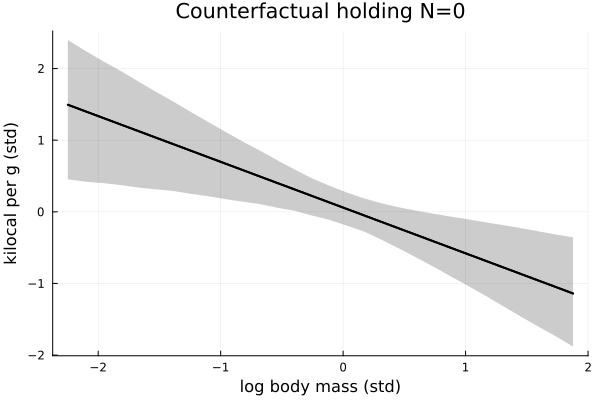

In [73]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

Plots.plot(title="Counterfactual holding N=0", 
    xlab="log body mass (std)", ylab="kilocal per g (std)")
Plots.plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

## 5.42 Simulate M → K ← N and M → N

In [133]:
# M → K ← N
# M → N
Random.seed!(100)
n = 100
@time M = rand(Normal(), n)
@time N = [rand(Normal(μ)) for μ ∈ M]
@time K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim = DataFrame(:K => K, :N => N, :M => M);

  0.000018 seconds (1 allocation: 896 bytes)
  0.032428 seconds (26.71 k allocations: 1.787 MiB, 94.95% compilation time)
  0.027939 seconds (26.71 k allocations: 1.788 MiB, 96.99% compilation time)


  0.325660 seconds (875.26 k allocations: 116.450 MiB, 19.42% gc time)
  0.312747 seconds (887.61 k allocations: 119.168 MiB, 19.19% gc time)
  0.581310 seconds (1.68 M allocations: 228.117 MiB, 14.29% gc time)


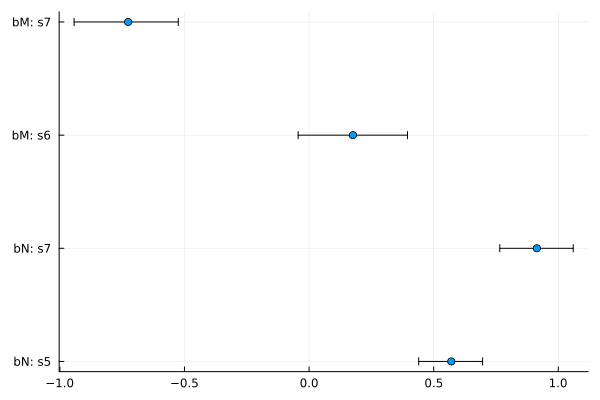

In [134]:
@time s5 = sample(model_m5_5(d_sim.N, d_sim.K), NUTS(), 1000)
@time s6 = sample(model_m5_6(d_sim.M, d_sim.K), NUTS(), 1000)
@time s7 = sample(model_m5_7(d_sim.N, d_sim.M, d_sim.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

In [135]:
precis(s5_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%       histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │ -0.0522  0.1044  -0.2129  -0.059  0.1206  ▁▂▂▄██▇▆▄▂▁▁▁▁ │
│    bN │  0.5706  0.0814   0.4397  0.5743  0.6962   ▁▁▁▂▄▆█▆▄▂▁▁▁ │
│     σ │   1.199  0.0893   1.0641  1.1963  1.3461        ▁▃██▃▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


In [136]:
precis(s6_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%   histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ -0.0565  0.1189  -0.2415  -0.0581  0.1349     ▁▄▇█▇▃▁ │
│    bM │  0.1758  0.1354  -0.0439   0.1757  0.3949  ▁▁▂▆██▄▂▁▁ │
│     σ │  1.4633  0.1003   1.3098   1.4612  1.6299    ▁▁▆█▆▂▁▁ │
└───────┴───────────────────────────────────────────────────────┘


In [137]:
precis(s7_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%    94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ -0.094  0.0923  -0.2377  -0.0934   0.0533   ▁▂▄▆██▆▄▂▁▁ │
│    bM │ -0.726  0.1285  -0.9428  -0.7247  -0.5249     ▁▁▂▅██▃▁▁ │
│    bN │  0.914  0.0936   0.7651   0.9182   1.0599  ▁▁▁▃▅▆█▇▄▂▁▁ │
│     σ │ 1.0402  0.0775   0.9266   1.0356   1.1627   ▁▁▄▇██▅▂▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


## 5.43 Two more simulations.
- Sim 2: M → K ← N and N → M.
- Sim 3: M → K ← N and M ← U → N

In [140]:
Random.seed!(100)

# M → K ← N
# N → M
n = 100
@time N = rand(Normal(), n)
@time M = [rand(Normal(μ)) for μ ∈ N]
@time K = [rand(Normal(μ)) for μ ∈ N .- M] 
@time d_sim2 = DataFrame(:K => K, :N => N, :M => M);

# M → K ← N
# M ← U → N
n = 100
@time U = rand(Normal(), n)
@time N = [rand(Normal(μ)) for μ ∈ U]
@time M = [rand(Normal(μ)) for μ ∈ U]
@time K = [rand(Normal(μ)) for μ ∈ N .- M] 
@time d_sim3 = DataFrame(:K => K, :N => N, :M => M);

  0.000019 seconds (1 allocation: 896 bytes)
  0.036760 seconds (26.71 k allocations: 1.787 MiB, 90.16% compilation time)
  0.031507 seconds (26.71 k allocations: 1.788 MiB, 94.57% compilation time)
  0.000092 seconds (29 allocations: 4.391 KiB)
  0.000017 seconds (1 allocation: 896 bytes)
  0.027651 seconds (26.71 k allocations: 1.787 MiB, 96.33% compilation time)
  0.118062 seconds (26.71 k allocations: 1.787 MiB, 74.61% gc time, 99.34% compilation time)
  0.027515 seconds (26.71 k allocations: 1.788 MiB, 95.88% compilation time)
  0.000045 seconds (29 allocations: 4.391 KiB)


### 5.43.1 Simulation 2

  0.345931 seconds (918.40 k allocations: 125.918 MiB, 17.94% gc time)
  0.325920 seconds (891.25 k allocations: 120.034 MiB, 20.14% gc time)
  0.603705 seconds (1.61 M allocations: 217.285 MiB, 17.79% gc time)


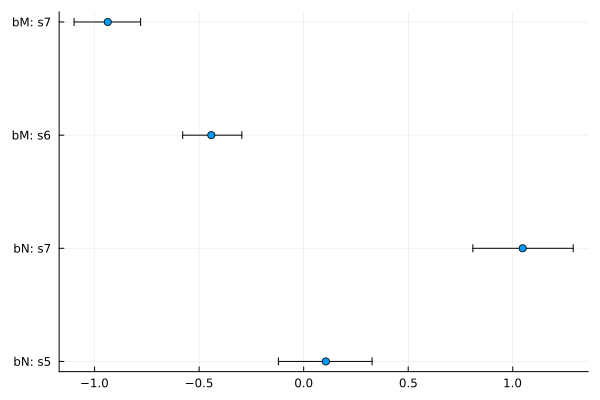

In [141]:
@time s5 = sample(model_m5_5(d_sim2.N, d_sim2.K), NUTS(), 1000)
@time s6 = sample(model_m5_6(d_sim2.M, d_sim2.K), NUTS(), 1000)
@time s7 = sample(model_m5_7(d_sim2.N, d_sim2.M, d_sim2.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

### 5.43.2 Simulation 3

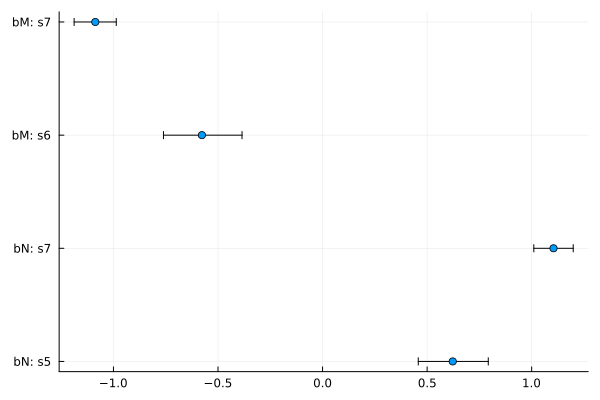

In [142]:
s5 = sample(model_m5_5(d_sim3.N, d_sim3.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim3.M, d_sim3.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim3.N, d_sim3.M, d_sim3.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

### 5.44 Markov-equivalent DAGs

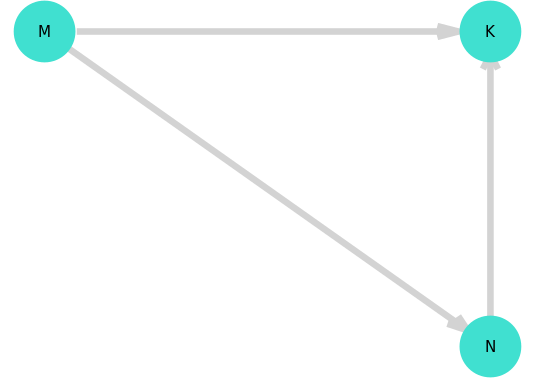

In [143]:
dag5_7 = Dagitty.DAG(:M => :K, :N => :K, :M => :N)
drawdag(dag5_7, [1, 0, 1], [0, 0, 1])

# equivalentDAGs is TODO in Dagitty.jl

# 5.3 Categorical variables

## 5.45 Load Howell1 Data

In [150]:
d = DataFrame(CSV.File("data/Howell1.csv"))
describe(d)

4×7 DataFrame
 Row │ variable  mean        min       median    max       nmissing  eltype   
     │ Symbol    Float64     Real      Float64   Real      Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ height    138.264     53.975    148.59    179.07           0  Float64
   2 │ weight     35.6106     4.25242   40.0578   62.9926         0  Float64
   3 │ age        29.3444     0.0       27.0      88.0            0  Float64
   4 │ male        0.472426   0          0.0       1              0  Int64

## 5.46 Simulate prior distribution female and male heights, with each of different variance

In [151]:
cnt = 10_000
μ_female = rand(Normal(178, 20), cnt)
μ_male = rand(Normal(178, 20), cnt) + rand(Normal(0, 10), cnt)
precis(DataFrame(:μ_female => μ_female, :μ_male => μ_male))

┌──────────┬────────────────────────────────────────────────────────┐
│    param │    mean      std     5.5%      50%    94.5%  histogram │
├──────────┼────────────────────────────────────────────────────────┤
│ μ_female │ 178.169  20.1479  145.798  178.163  210.106  ▁▁▄██▃▁▁▁ │
│   μ_male │ 177.812  22.5377   141.62  177.739  213.741  ▁▁▁▅██▄▁▁ │
└──────────┴────────────────────────────────────────────────────────┘


## 5.47 Encode sex as an index variable

In [152]:
d[!,:sex] = ifelse.(d.male .== 1, 2, 1)
describe(d.sex)

Summary Stats:
Length:         544
Missing Count:  0
Mean:           1.472426
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   2.000000
Maximum:        2.000000
Type:           Int64


In [156]:
@show size(d)
first(d, 3)

size(d) = (29, 8)


3×8 DataFrame
 Row │ clade          species         kcal_per_g  perc_fat  perc_protein  perc ⋯
     │ String31       String31        Float64     Float64   Float64       Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42       ⋯
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85
                                                               3 columns omitted

## 5.48 A Model based on sex being an index variable 

In [154]:
@model function model_m5_8(sex, height)
    σ ~ Uniform(0, 50)
    a ~ MvNormal([178, 178], 20)
    height ~ MvNormal(a[sex], σ)
end

@time m5_8 = sample(model_m5_8(d.sex, d.height), NUTS(), 1000)
@time m5_8_df = DataFrame(m5_8)
precis(m5_8_df)

  2.571362 seconds (2.00 M allocations: 497.385 MiB, 8.02% gc time, 82.51% compilation time: 83% of which was recompilation)
  0.000069 seconds (88 allocations: 52.984 KiB)
┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │ 134.875   1.583  132.336  134.841  137.489   ▁▁▁▃▆██▆▂▁▁ │
│  a[2] │   142.6  1.7744  139.806  142.634  145.348  ▁▁▁▂▅▇██▆▃▁▁ │
│     σ │ 27.4457  0.8132  26.2294  27.3949  28.8616  ▁▁▃██▇▆▃▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


## 5.49 Precision of the contrast (difference between male and female heights)

In [84]:
m5_8_df[!,:diff_fm] = m5_8_df[:,"a[1]"] - m5_8_df[:,"a[2]"]
precis(m5_8_df)

┌─────────┬───────────────────────────────────────────────────────────┐
│   param │    mean     std      5.5%      50%    94.5%     histogram │
├─────────┼───────────────────────────────────────────────────────────┤
│    a[1] │ 134.857  1.5237   132.408  134.842  137.249   ▁▁▁▃▆██▅▂▁▁ │
│    a[2] │ 142.605  1.6091   140.003  142.629    145.1   ▁▁▂▄▆█▇▅▂▁▁ │
│       σ │ 27.4361  0.8641   26.0253    27.39  28.9284  ▁▁▂▃▆█▇▅▃▂▁▁ │
│ diff_fm │  -7.748  2.1962  -11.2189  -7.7422  -4.2098      ▁▁▃██▄▂▁ │
└─────────┴───────────────────────────────────────────────────────────┘


## 5.50 Load Milk dataset

In [155]:
@time d = DataFrame(CSV.File("data/milk.csv"))

# get rid of dots in column names
@time rename!(n -> replace(n, "." => "_"), d)

@time levels(d.clade)

  0.019587 seconds (5.74 k allocations: 355.748 KiB, 85.80% compilation time)
  0.039193 seconds (27.07 k allocations: 1.802 MiB, 99.67% compilation time)
  0.273344 seconds (200.08 k allocations: 13.523 MiB, 99.98% compilation time)


4-element Vector{String31}:
 "Ape"
 "New World Monkey"
 "Old World Monkey"
 "Strepsirrhine"

In [158]:
?levels

search: levels levelsmap AboveMaxLevel LogLevel BelowMinLevel



```
levels(x; skipmissing=true)
```

Return a vector of unique values which occur or could occur in collection `x`. `missing` values are skipped unless `skipmissing=false` is passed.

Values are returned in the preferred order for the collection, with the result of [`sort`](@ref) as a default. If the collection is not sortable then the order of levels is unspecified.

Contrary to [`unique`](@ref), this function may return values which do not actually occur in the data, and does not preserve their order of appearance in `x`.


## 5.51 Create a new index variable (clade_id) to encode clade

In [159]:
d[!,:clade_id] = indexin(d.clade, levels(d.clade));

In [160]:
first(d,3)

3×9 DataFrame
 Row │ clade          species         kcal_per_g  perc_fat  perc_protein  perc ⋯
     │ String31       String31        Float64     Float64   Float64       Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42       ⋯
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85
                                                               4 columns omitted

In [161]:
typeof(d[:, :clade_id])

Vector{Union{Nothing, Int64}} (alias for Array{Union{Nothing, Int64}, 1})

In [ ]:
?indexin

In [165]:
?nothing

search: nothing Nothing isnothing NoncentralChisq NoncentralHypergeometric



```
nothing
```

The singleton instance of type [`Nothing`](@ref), used by convention when there is no value to return (as in a C `void` function) or when a variable or field holds no value.

See also: [`isnothing`](@ref), [`something`](@ref), [`missing`](@ref).


## 5.52 Model each clade index variable with a different $\mu$ height

  8.221745 seconds (8.31 M allocations: 598.871 MiB, 8.29% gc time, 94.83% compilation time)
size(m5_9_df) = (1000, 5)
first(m5_9_df, 3) = 3×5 DataFrame
 Row │ a[1]       a[2]        a[3]      a[4]       σ
     │ Float64    Float64     Float64   Float64    Float64
─────┼──────────────────────────────────────────────────────
   1 │ -0.121308  -0.0189059  0.545328  -0.690323  0.800044
   2 │ -0.873119   0.709481   0.686723  -0.643273  0.673892
   3 │ -0.117898   0.344307   0.805761  -0.635514  0.724761
first(m5_9_df, 3) = 3×5 DataFrame
 Row │ a1         a2          a3        a4         σ
     │ Float64    Float64     Float64   Float64    Float64
─────┼──────────────────────────────────────────────────────
   1 │ -0.121308  -0.0189059  0.545328  -0.690323  0.800044
   2 │ -0.873119   0.709481   0.686723  -0.643273  0.673892
   3 │ -0.117898   0.344307   0.805761  -0.635514  0.724761
  0.263190 seconds (332.05 k allocations: 22.350 MiB, 18.54% gc time, 99.01% compilation time)


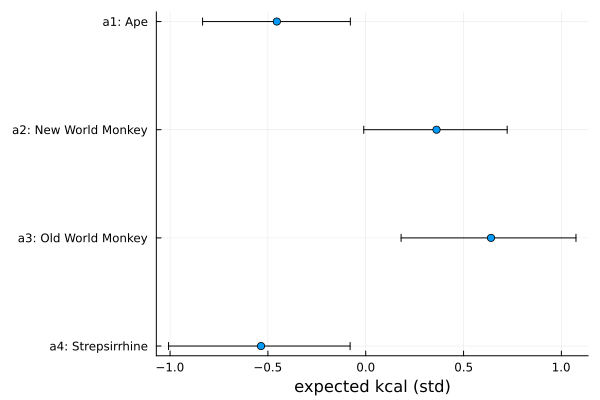

In [166]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g);
clade_counts = maximum(levels(d.clade_id))

@model function model_m5_9(clade_id, K)
    clade_μ = zeros(clade_counts)
    a ~ MvNormal(clade_μ, 0.5)
    σ ~ Exponential(1)
    K ~ MvNormal(a[clade_id], σ)
end

@time m5_9 = sample(model_m5_9(d.clade_id, d.K), NUTS(), 1000)
m5_9_df = DataFrame(m5_9)
@show size(m5_9_df)
@show first(m5_9_df, 3)

# get rid of square brackets in parameter names
rename!(n -> replace(n, r"\[|\]" => ""), m5_9_df)
@show first(m5_9_df, 3)


# parameter names
pars = [:a1, :a2, :a3, :a4]
p_names = map(v -> "$(v[1]): $(v[2])", zip(pars, levels(d.clade)))


@time coeftab_plot(m5_9_df; pars=pars, pars_names=p_names, xlab="expected kcal (std)")

In [173]:
precis(m5_9_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│    a1 │ -0.4544  0.2419  -0.8338  -0.4678  -0.0786    ▁▂▆█▇▃▁▁▁ │
│    a2 │  0.3619   0.233  -0.0101   0.3613    0.723     ▁▂▅██▄▁▁ │
│    a3 │  0.6403   0.278   0.1808   0.6405   1.0745    ▁▁▂▄██▇▃▁ │
│    a4 │ -0.5351   0.294  -1.0078  -0.5405  -0.0798  ▁▁▂▄▇█▆▃▁▁▁ │
│     σ │   0.803  0.1239   0.6257   0.7882   1.0101    ▁▅█▇▄▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


## 5.53 Add an artificial index variable "House" (like Harrypotter house)

In [168]:
# it took me a while to find a seed which make Slytherin to stand out. 
# So it is just a seed, not the model property
Random.seed!(31)
d[!,:house] = sample(1:4, nrow(d));

In [170]:
first(d,3)

3×11 DataFrame
 Row │ clade          species         kcal_per_g  perc_fat  perc_protein  perc ⋯
     │ String31       String31        Float64     Float64   Float64       Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Strepsirrhine  Eulemur fulvus        0.49     16.6          15.42       ⋯
   2 │ Strepsirrhine  E macaco              0.51     19.27         16.91
   3 │ Strepsirrhine  E mongoz              0.46     14.11         16.85
                                                               6 columns omitted

## 5.54 A model with $\mu$ = clade + house

In [172]:
house_counts = maximum(levels(d.house))

@model function model_m5_10(clade_id, house, K)
    clade_μ = zeros(clade_counts)
    house_μ = zeros(house_counts)
    a ~ MvNormal(clade_μ, 0.5)
    h ~ MvNormal(house_μ, 0.5)
    σ ~ Exponential(1)
    μ = a[clade_id] .+ h[house]
    K ~ MvNormal(μ, σ)
end

@time m5_10 = sample(model_m5_10(d.clade_id, d.house, d.K), NUTS(), 1000)
m5_10_df = DataFrame(m5_10)
precis(m5_10_df)

  3.703004 seconds (3.04 M allocations: 484.631 MiB, 6.45% gc time, 78.12% compilation time: 87% of which was recompilation)
┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.5267  0.3057  -0.9947  -0.5396  -0.0013    ▁▁▂▅██▆▃▂▁▁ │
│  a[2] │  0.4038  0.2924  -0.0701   0.4086   0.8694     ▁▂▆██▆▂▁▁▁ │
│  a[3] │  0.5736  0.3293   0.0235   0.5778   1.0687   ▁▁▂▃▆██▆▂▁▁▁ │
│  a[4] │ -0.4833   0.327  -0.9725  -0.4874   0.0469  ▁▁▁▂▅██▇▅▂▁▁▁ │
│  h[1] │  0.0517  0.3073  -0.4366   0.0523   0.5656     ▁▂▅██▆▃▂▁▁ │
│  h[2] │  0.1088  0.2859  -0.3586   0.1062   0.5777    ▁▁▁▃▆█▆▄▂▁▁ │
│  h[3] │ -0.3501  0.3315    -0.89  -0.3528   0.1691        ▁▁▅█▃▁▁ │
│  h[4] │  0.0847  0.2944  -0.4016   0.1025   0.5328    ▁▁▂▄▇█▇▃▁▁▁ │
│     σ │  0.8061  0.1304   0.6252   0.7905   1.0232      ▁▅█▇▄▂▁▁▁ │
└───────┴──────────────────────────